In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:

# Load datasets
train_path = "/content/DIA_trainingset_RDKit_descriptors.csv"
test_path = "/content/DIA_testset_RDKit_descriptors.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

<ipython-input-50-b1dbf152e372>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Label", data=train_df, palette="viridis")


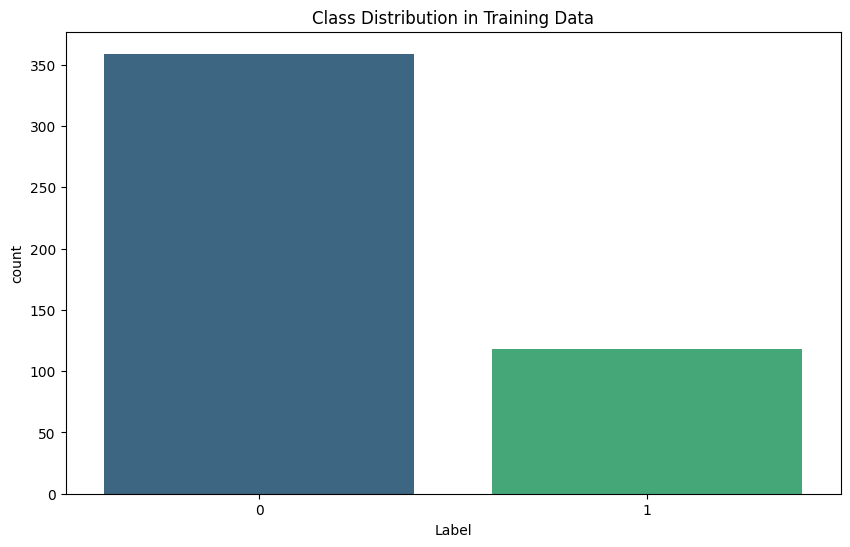

In [ ]:
# Exploratory Data Analysis (EDA) on training data
plt.figure(figsize=(10, 6))
sns.countplot(x="Label", data=train_df, palette="viridis")
plt.title("Class Distribution in Training Data")
plt.show()


In [ ]:
# Print class distribution before balancing
print("Class distribution before balancing:")
print(train_df["Label"].value_counts())

Class distribution before balancing:
Label
0    359
1    118
Name: count, dtype: int64


In [ ]:
# Handle class imbalance using SMOTE
X_train = train_df.drop(columns=["Label", "SMILES"])
y_train = train_df["Label"]
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Print class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution after SMOTE:
Label
0    359
1    359
Name: count, dtype: int64


<ipython-input-54-f41faeb93f25>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette="coolwarm")


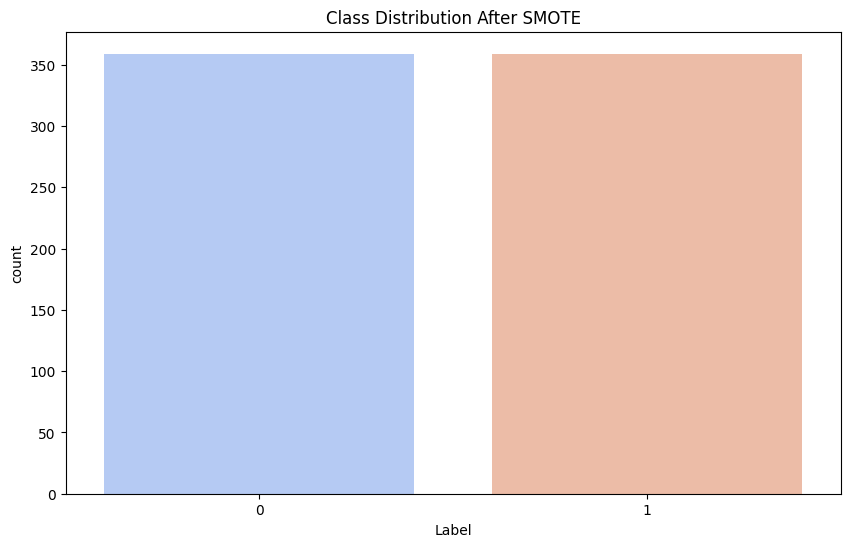

In [ ]:
# Visualizing class distribution after SMOTE
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_resampled, palette="coolwarm")
plt.title("Class Distribution After SMOTE")
plt.show()

In [ ]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test = test_df.drop(columns=["Label", "SMILES"])
y_test = test_df["Label"]
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Feature Selection using Lasso Regression
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train_resampled)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

print(f"Original feature count: {X_train.shape[1]}")
print(f"Selected feature count after Lasso: {X_train_selected.shape[1]}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028813927227773206, tolerance: 0.014124216027874543
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03038339065242468, tolerance: 0.014124216027874543
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02829853396210069, tolerance: 0.014124216027874543
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681

Original feature count: 196
Selected feature count after Lasso: 92


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.270172556543997, tolerance: 0.013485913043478277
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.111334723188726, tolerance: 0.013485913043478277
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.561871063799643, tolerance: 0.013485913043478277
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Conve

In [ ]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=30)  # Keep top 30 principal components
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

print(f"Feature count after PCA: {X_train_pca.shape[1]}")

Feature count after PCA: 30


In [ ]:
# Define classifiers
models = {
    "Gaussian Process Classifier": GaussianProcessClassifier(kernel=C(1.0) * RBF(length_scale=1.0), random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel="rbf", probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

In [ ]:
# Train and evaluate models
results = {}
best_models = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_pca, y_train_resampled)
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    best_models[name] = model

    print(f"{name} Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))



Training Gaussian Process Classifier...
Gaussian Process Classifier Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84        90
           1       0.52      0.43      0.47        30

    accuracy                           0.76       120
   macro avg       0.67      0.65      0.66       120
weighted avg       0.75      0.76      0.75       120


Training Random Forest...
Random Forest Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85        90
           1       0.52      0.37      0.43        30

    accuracy                           0.76       120
   macro avg       0.67      0.63      0.64       120
weighted avg       0.74      0.76      0.74       120


Training Support Vector Machine...
Support Vector Machine Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

     

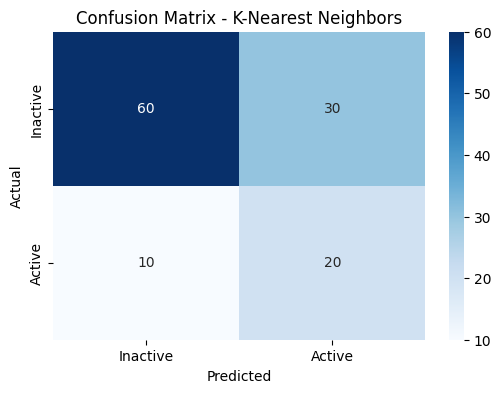

In [ ]:
    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["Inactive", "Active"], yticklabels=["Inactive", "Active"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

<Figure size 1000x600 with 0 Axes>

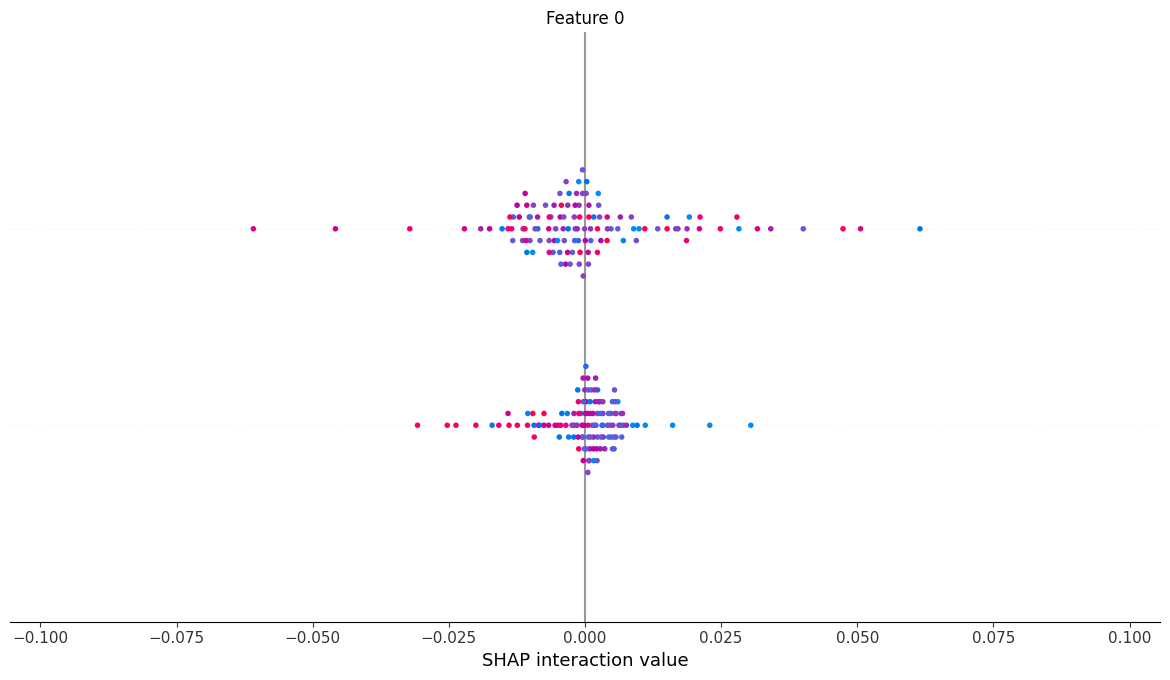

In [ ]:
# SHAP Model Explainability (Using Random Forest as example)
explainer = shap.Explainer(best_models["Random Forest"], X_test_pca)
shap_values = explainer(X_test_pca)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_pca)
plt.show()


In [ ]:
# Ensemble Learning - Voting Classifier
ensemble_model = VotingClassifier(estimators=[
    ("RF", best_models["Random Forest"]),
    ("SVM", best_models["Support Vector Machine"]),
    ("LR", best_models["Logistic Regression"]),
    ("KNN", best_models["K-Nearest Neighbors"])
], voting='hard')

ensemble_model.fit(X_train_pca, y_train_resampled)
y_pred_ensemble = ensemble_model.predict(X_test_pca)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"\nEnsemble Model Accuracy: {ensemble_accuracy:.2f}")




Ensemble Model Accuracy: 0.72


<ipython-input-63-bfbb430160b9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()) + ["Ensemble"], y=list(results.values()) + [ensemble_accuracy], palette="magma")


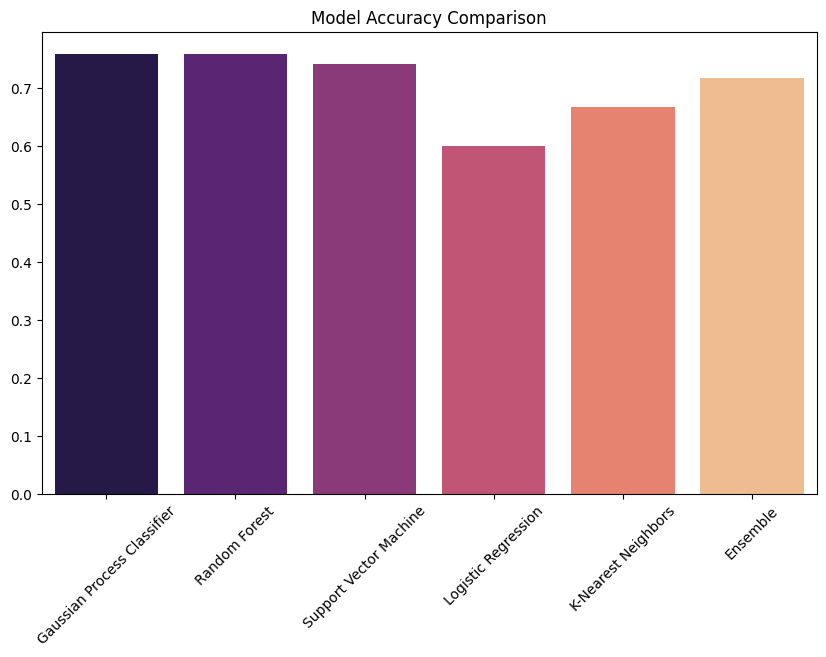

In [ ]:
# Plot model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()) + ["Ensemble"], y=list(results.values()) + [ensemble_accuracy], palette="magma")
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.show()
